In [1]:
import sys
import os
PROJ_PATH = os.getcwd()
SRC_PATH = os.path.join(PROJ_PATH, 'src')
sys.path.append(PROJ_PATH)
sys.path.append(SRC_PATH)

In [2]:
from torch.utils.data import Dataset, DataLoader
from src.model import FacialGNN, FacialTemporalTransformer, MicroExpressionModel
from src.training import prepare_microexpression_datasets, MicroExpressionDataset, me_collate_fn

train_list, val_list, label_map = prepare_microexpression_datasets(seed=1, subject_independent=False, include_augmented=False)
len(train_list), len(val_list), label_map

e:\Programs\miniconda\envs\microexpressions\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  Train fragments: 628, Val fragments: 158
Target distribution train: {'vii': 0.40923566878980894, 'iii': 0.2786624203821656, 'ii': 0.18630573248407642, 'v': 0.05732484076433121, 'iv': 0.04777070063694268, 'i': 0.01751592356687898, 'vi': 0.0031847133757961785}
Target distribution val: {'vii': 0.41139240506329117, 'iii': 0.27848101265822783, 'ii': 0.18354430379746836, 'v': 0.056962025316455694, 'iv': 0.04430379746835443, 'i': 0.0189873417721519, 'vi': 0.006329113924050633}


(628, 158, {'ii': 0, 'iii': 1, 'i': 2, 'vii': 3, 'v': 4, 'iv': 5, 'vi': 6})

In [6]:
train_dataset = MicroExpressionDataset(train_list, label_map)
val_dataset = MicroExpressionDataset(val_list, label_map)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=me_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, collate_fn=me_collate_fn)

fusion_dim = 256
embed_dim = 256
model = MicroExpressionModel(
    gnn=FacialGNN(fusion_dim=fusion_dim),
    transformer=FacialTemporalTransformer(embed_dim=embed_dim),
    num_classes=len(label_map),
    embed_dim=embed_dim
)

for lm_list, labels, num_frames in train_loader:
    res = model(lm_list, num_frames)
    display(res.shape)
    break

e:\Programs\miniconda\envs\microexpressions\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([4, 7])

tensor([[ 0,  1,  2,  3,  5,  6,  7,  8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21,
         22, 23, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
         43, 44, 45, 46, 47, 48, 49, 19, 25, 31, 43,  4,  5, 13,  0,  4,  5,  9,
         21, 22, 23, 25, 26, 30, 19, 22, 23, 24, 25, 28, 29, 30, 31, 32, 36, 37,
         31, 37,  1,  2,  3,  4,  6,  7,  8,  9, 11, 12, 13, 15, 16, 17, 18, 20,
         21, 22, 23, 24, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40,
         41, 42, 44, 45, 46, 47, 48, 49, 50, 24, 30, 42, 50, 10, 10, 16, 19, 22,
         25, 28, 10, 10, 10, 10, 10, 10, 14, 14, 14, 14, 18, 18, 18, 18, 14, 14,
         18, 18, 43, 47],
        [ 1,  2,  3,  4,  6,  7,  8,  9, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22,
         23, 24, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
         44, 45, 46, 47, 48, 49, 50, 24, 30, 42, 50, 10, 10, 16, 19, 22, 25, 28,
         10, 10, 10, 10, 10, 10, 14, 14, 14, 14, 18, 18, 18, 18, 14, 14, 18, 18,
  

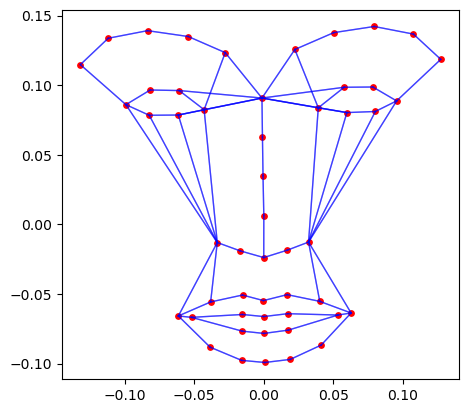

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from src.procrustes import normalize_points

meanface_file = r"models\meanface.txt"
with open(meanface_file) as f:
    meanface = f.readlines()[0]

meanface = meanface.strip().split()
meanface = [float(x) for x in meanface]
meanface = np.array(meanface).reshape(-1, 2)

meanface_n, _, _ = normalize_points(meanface)
meanface_n = torch.tensor(meanface_n)

x, edge_index = MicroExpressionModel.build_graph(meanface_n)
display(edge_index)

for i in range(edge_index.shape[1]):
    src = edge_index[0, i].item()
    tgt = edge_index[1, i].item()
    plt.plot(
        [x[src, 0], x[tgt, 0]],
        [-x[src, 1], -x[tgt, 1]],
        c='blue', alpha=0.5, linewidth=1
    )

plt.scatter(x[:,0], -x[:, 1], c='red', s=15)
plt.gca().set_aspect('equal')
